In [5]:
# Set up
import os
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sbn
import boto
import boto3
import io
import csv
import warnings
import numpy as np
from sklearn import preprocessing
%matplotlib inline
path = '/Users/sheri/documents/data science/data mining/homework/project 1'

os.listdir(path)

['.ipynb_checkpoints',
 'FaultCode_DowntimeMapping.xlsx',
 'LGW_Down_Turbine_Tracker.xlsx',
 'Lightning.csv',
 'Meteorological data writeup.docx',
 'Meteorological_Notebook_SAL.py',
 'MetTower (1).ipynb',
 'MetTower.ipynb',
 'MetTower_complete.csv',
 'MetTower_LGW_2017.csv',
 'PowerCurveData.csv',
 'PowerCurves.csv',
 'Siemens Error Code Stop and Reset Details.xlsx',
 'Siemens_Fault_Code_Descriptions.xlsx',
 'tblSCTurbine.csv',
 'WpsHistoryDescription_V_310.pdf']

I wanted to look at the meteorological data to see how much that could help explain turbine performance. The factors I looked at were Barometric Pressure, Humidity, and Air Temperature (measured at 3meters and at 76 meters to see if a temperature differential makes a difference).

In [29]:
#reading in meteorlogical data for 2017
df_m = pd.read_csv(path + '/MetTower_LGW_2017.csv')
df_m.head()
df_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52560 entries, 0 to 52559
Data columns (total 22 columns):
TmStamp                    52560 non-null object
RecNum                     52560 non-null int64
WS_P2546a_80m_Avg          52560 non-null float64
WS_Thies_80m_Avg           52560 non-null float64
Windsp_3D_Avg              52560 non-null float64
WindDir_Angle_3D_Avg       52560 non-null float64
Elevation_angle_3D_Avg     52560 non-null float64
Temp_3D_Avg                52560 non-null float64
WindDir_76m_D1_WVT         52560 non-null float64
WindDir_76m_SD1_WVT        52560 non-null float64
WindDir_ICEFREE_D1_WVT     52560 non-null float64
WindDir_ICEFREE_SD1_WVT    52560 non-null float64
WS_ICEFREE_Avg             52560 non-null float64
AirTC_76m_Avg              52555 non-null float64
RH_76m_Avg                 52560 non-null float64
BP_mbar_76m_Avg            52560 non-null float64
WS_Thies_60m_Avg           52560 non-null float64
WS_Thies_26m_Avg           52560 non-null fl

In [3]:
#reading in turbine performance data
df_p = pd.read_csv(path + '/tblSCTurbine.csv')

df_p.head()




,Name,TimeStamp,wtc_CurTime_endvalue,wtc_SecAnemo_mean,wtc_YawPos_mean,wtc_GenRpm_mean,wtc_HubLubGr_mean,wtc_IceDetec_mean,wtc_IMidBa_mean,wtc_IMidCa_mean,...,wtc_ReactRef_endvalue,wtc_ScYawPos_mean,wtc_PrWindSp_mean,wtc_SeWindSp_mean,wtc_AcWindSp_mean,wtc_NacelPos_mean,wtc_TetAnemo_mean,wtc_TetAnFrq_mean,wtc_TowerFrq_Frequenc_mean,wtc_BoostAva_mean
0,T010,2015-05-19 23:00:00.000,2015-05-19 22:59:56.000,8.026840,40.70000,0.6,NaN,NaN,NaN,NaN,...,NaN,40.70000,9.485412,8.017353,9.485392,40.70000,NaN,0.01,0.2004,0.0
1,T010,2015-05-19 23:10:00.000,2015-05-19 23:09:56.000,8.709124,12.69578,0.6,NaN,NaN,NaN,NaN,...,NaN,10.96358,8.437153,8.697805,8.437179,12.70296,NaN,0.01,0.2004,0.0
2,T010,2015-05-19 23:20:00.000,2015-05-19 23:19:56.000,10.432920,311.68360,0.6,NaN,NaN,NaN,NaN,...,NaN,68.03295,10.836880,10.431380,10.836890,311.68570,NaN,0.01,0.2004,0.0
3,T010,2015-05-19 23:30:00.000,2015-05-19 23:29:56.000,8.176679,164.15750,0.6,NaN,NaN,NaN,NaN,...,NaN,-194.58410,9.402458,8.174048,9.402458,164.16360,NaN,0.01,0.2004,0.0
4,T010,2015-05-19 23:40:00.000,2015-05-19 23:39:56.000,8.793220,151.80000,0.6,NaN,NaN,NaN,NaN,...,NaN,-208.20000,9.098410,8.795180,9.098390,151.80000,NaN,0.01,0.2004,0.0


### [10 points] Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file.

In [30]:

#selecting columns of interest from the meteorological data set 
df_m = df_m[['TmStamp', 'RH_76m_Avg', 'BP_mbar_76m_Avg', 'AirTC_3m_Avg','AirTC_76m_Avg']]

# Need to convert TimeStamp from object to datetime
df_m['TmStamp'] = pd.to_datetime(df_m['TmStamp'])
df_m.info()

# setting the index by Timestamp adds plotting functionality and drops the column.
df_m.set_index('TmStamp', inplace=True)
df_m.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52560 entries, 0 to 52559
Data columns (total 5 columns):
TmStamp            52560 non-null datetime64[ns]
RH_76m_Avg         52560 non-null float64
BP_mbar_76m_Avg    52560 non-null float64
AirTC_3m_Avg       52560 non-null float64
AirTC_76m_Avg      52555 non-null float64
dtypes: datetime64[ns](1), float64(4)
memory usage: 2.0 MB


,RH_76m_Avg,BP_mbar_76m_Avg,AirTC_3m_Avg,AirTC_76m_Avg
count,52560.000000,52560.000000,52560.000000,52555.000000
mean,87.635148,948.597028,18.729007,19.103376
std,21.409412,13.307139,9.097717,8.253068
min,35.330000,601.400000,-12.920000,-9.450000
25%,70.790000,948.000000,12.540000,13.960000
50%,88.300000,950.000000,20.030000,20.310000
75%,106.100000,950.000000,25.170000,24.860000
max,127.700000,971.000000,39.960000,74.950000


The meteorological factors chosen to represent potential hindrances to turbine performance are:

Relative Humidity (RH_76m_Avg): mean 87%, standard deviation of 21%
    The 75% and maximum value is troubling since they are both above 100%.
    Looking at the spread, normalizing the data is the next step.

Barometric Pressure (BP_mbar_76m_Avg): mean 949 mbar, standard deviation 13 mbar
    
Air Temperature at 3 meters (AirTC_3m_Avg): mean 19 C, standard deviation 9 C

Air Temperature at 76 meters (AirTC_76m_Avg): mean 19 C, standard deviation 8 C

In [46]:
#Normalizing the Relative Humidity data 

#Code from https://chrisalbon.com/python/data_wrangling/pandas_normalize_column/

# Create x, where x the 'scores' column's values as floats
x = df_m[['RH_76m_Avg']].values.astype(float)

# Create a minimum and maximum processor object
min_max_scaler = preprocessing.MinMaxScaler()

# Create an object to transform the data to fit minmax processor
x_scaled = min_max_scaler.fit_transform(x)

# Run the normalizer on the dataframe
df_normalized = pd.DataFrame(x_scaled)

df_normalized.describe()


,0
count,52560.000000
mean,0.566257
std,0.231779
min,0.000000
25%,0.383891
50%,0.573455
75%,0.766158
max,1.000000


The turbine performance factors are:

Generator mean RPM (wtc_GenRpm_mean): mean 1061 rpm, standard deviation 374 rpm

Mean Wind Speed (wtc_AcWindSp_mean): mean 7 m/s, standard deviation 3 m/s

In [24]:
#selecting columns of interest from the turbine performance data set
df_p = df_p[['TimeStamp', 'wtc_GenRpm_mean', 'wtc_AcWindSp_mean']]
# Need to convert TimeStamp from object to datetime
df_p['TimeStamp'] = pd.to_datetime(df_p['TimeStamp'])
df_p.info()

# setting the index by Timestamp adds plotting functionality and drops the column.
df_p.set_index('TimeStamp', inplace=True)
# choosing only the 2017 data 
df_p = df_p['2017-01-01':'2017-12-31']
df_p.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12742244 entries, 0 to 12742243
Data columns (total 3 columns):
TimeStamp            datetime64[ns]
wtc_GenRpm_mean      float64
wtc_AcWindSp_mean    float64
dtypes: datetime64[ns](1), float64(2)
memory usage: 291.6 MB


,wtc_GenRpm_mean,wtc_AcWindSp_mean
count,4.544014e+06,4.544012e+06
mean,1.061432e+03,7.332382e+00
std,3.737631e+02,3.351140e+00
min,0.000000e+00,0.000000e+00
25%,7.857581e+02,4.856888e+00
50%,1.118130e+03,7.302492e+00
75%,1.425762e+03,9.678631e+00
max,1.536929e+03,2.892444e+01


In [32]:
#Merging the meteorlogical and performance data
df = df_m.merge(df_p,left_index=True,right_index=True)
df.describe()


,RH_76m_Avg,BP_mbar_76m_Avg,AirTC_3m_Avg,AirTC_76m_Avg,wtc_GenRpm_mean,wtc_AcWindSp_mean
count,4.544868e+06,4.544868e+06,4.544868e+06,4.544434e+06,4.544014e+06,4.544012e+06
mean,8.765814e+01,9.485993e+02,1.873094e+01,1.910499e+01,1.061432e+03,7.332382e+00
std,2.140692e+01,1.327567e+01,9.097229e+00,8.256878e+00,3.737631e+02,3.351140e+00
min,3.533000e+01,6.014000e+02,-1.292000e+01,-9.450000e+00,0.000000e+00,0.000000e+00
25%,7.081000e+01,9.480000e+02,1.255000e+01,1.396000e+01,7.857581e+02,4.856888e+00
50%,8.840000e+01,9.500000e+02,2.004000e+01,2.032000e+01,1.118130e+03,7.302492e+00
75%,1.061000e+02,9.500000e+02,2.517000e+01,2.486000e+01,1.425762e+03,9.678631e+00
max,1.277000e+02,9.710000e+02,3.996000e+01,7.495000e+01,1.536929e+03,2.892444e+01


### [15 points] Verify data quality: Explain any missing values, duplicate data, and outliers. Are those mistakes? How do you deal with these problems? Give justifications for your methods.

In [33]:
#Investigating data quality
#Find any missing values
null_data = df[df.isnull().any(axis=1)]

null_data

,RH_76m_Avg,BP_mbar_76m_Avg,AirTC_3m_Avg,AirTC_76m_Avg,wtc_GenRpm_mean,wtc_AcWindSp_mean
2017-01-06 18:20:00,86.80,959.0,-5.581,-6.492,NaN,NaN
2017-01-12 22:40:00,91.40,954.0,10.260,9.520,NaN,NaN
2017-01-12 23:30:00,93.40,955.0,9.450,8.650,NaN,NaN
2017-01-15 08:40:00,120.80,953.0,6.503,NaN,685.70370,3.465877
2017-01-15 08:40:00,120.80,953.0,6.503,NaN,659.30260,3.386105
2017-01-15 08:40:00,120.80,953.0,6.503,NaN,1237.45700,8.445127
2017-01-15 08:40:00,120.80,953.0,6.503,NaN,1045.85000,6.359073
2017-01-15 08:40:00,120.80,953.0,6.503,NaN,1249.41100,8.623986
2017-01-15 08:40:00,120.80,953.0,6.503,NaN,1266.21100,8.444840
2017-01-15 08:40:00,120.80,953.0,6.503,NaN,35.47148,6.300428


There are 1290 rows with missing values. Removing null value rows.

In [35]:
#Removing null values
df = df[pd.notnull(df['wtc_AcWindSp_mean'])]
df = df[pd.notnull(df['wtc_GenRpm_mean'])]
df = df[pd.notnull(df['AirTC_76m_Avg'])]

#Retest for nulls
null_data = df[df.isnull().any(axis=1)]

null_data

,RH_76m_Avg,BP_mbar_76m_Avg,AirTC_3m_Avg,AirTC_76m_Avg,wtc_GenRpm_mean,wtc_AcWindSp_mean


In [36]:
df.describe()

,RH_76m_Avg,BP_mbar_76m_Avg,AirTC_3m_Avg,AirTC_76m_Avg,wtc_GenRpm_mean,wtc_AcWindSp_mean
count,4.543578e+06,4.543578e+06,4.543578e+06,4.543578e+06,4.543578e+06,4.543578e+06
mean,8.765462e+01,9.485995e+02,1.873050e+01,1.910454e+01,1.061432e+03,7.332482e+00
std,2.140572e+01,1.327733e+01,9.097581e+00,8.257060e+00,3.737764e+02,3.351254e+00
min,3.533000e+01,6.014000e+02,-1.292000e+01,-9.450000e+00,0.000000e+00,0.000000e+00
25%,7.081000e+01,9.480000e+02,1.255000e+01,1.396000e+01,7.857418e+02,4.856781e+00
50%,8.840000e+01,9.500000e+02,2.004000e+01,2.032000e+01,1.118142e+03,7.302691e+00
75%,1.061000e+02,9.500000e+02,2.517000e+01,2.486000e+01,1.425781e+03,9.678937e+00
max,1.277000e+02,9.710000e+02,3.996000e+01,7.495000e+01,1.536929e+03,2.892444e+01


Updated values

Relative Humidity (RH_76m_Avg): mean 87%, standard deviation of 21%
    The 75% and maximum value is troubling since they are both above 100%.
    Looking at the spread, normalizing the data is the next step.

Barometric Pressure (BP_mbar_76m_Avg): mean 949 mbar, standard deviation 13 mbar
    
Air Temperature at 3 meters (AirTC_3m_Avg): mean 19 C, standard deviation 9 C

Air Temperature at 76 meters (AirTC_76m_Avg): mean 19 C, standard deviation 8 C

Generator mean RPM (wtc_GenRpm_mean): mean 1061 rpm, standard deviation 374 rpm

Mean Wind Speed (wtc_AcWindSp_mean): mean 7 m/s, standard deviation 3 m/s

### [10 points] Visualize appropriate statistics (e.g., range, mode, mean, median, variance, counts) for a subset of attributes. Describe anything meaningful you found from this or if you found something potentially interesting. Note: You can also use data from other sources for comparison. Explain why the statistics run are meaningful.

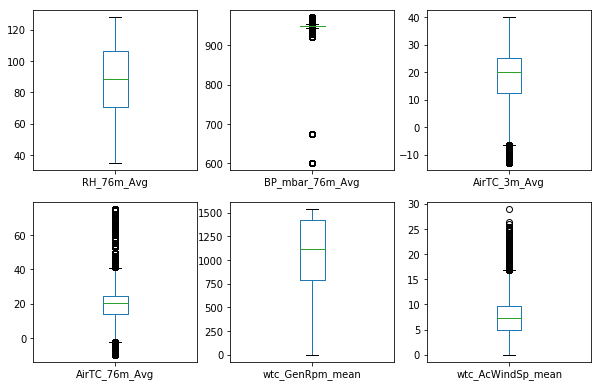

In [39]:
df.plot(kind='box', subplots=True, layout=(3,3), figsize=(10,10), sharex=False, sharey=False)
plt.show()


Using box plots we can see each factor in more detail. The variation within the three meter measure of temperature is clearly more variable than the 76 meter measure but there are more outliers within the 76 meter measure.
The barometric pressure shows the same stability although a couple of storms clearly happened and are shown as outliers.
While the humidity has a wide variation, the values are very consistent (few outliers) and are as expected in the Dallas, Texas region.


### [15 points] Visualize the most interesting attributes (at least 5 attributes, your opinion on what is interesting). Important: Interpret the implications for each visualization. Explain for each attribute why the chosen visualization is appropriate.

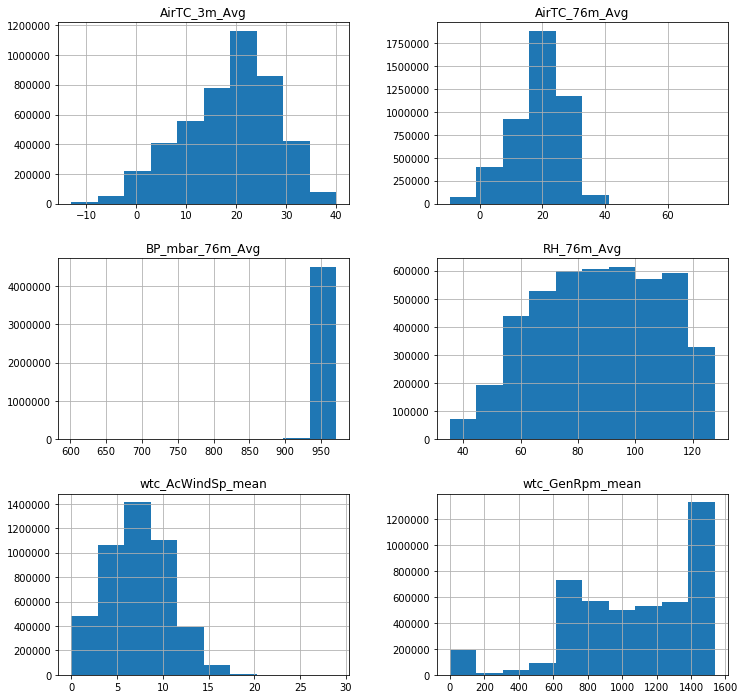

In [40]:
#Plots of interesting factors. 
#Code From: https://machinelearningmastery.com/visualize-machine-learning-data-python-pandas/
df.hist(figsize=(12,12))
plt.show()



I plotted histograms on the various factors to get a better idea of how each factor varied over time.
In the histograms we can see that the temperature at three meters height is more variable than the temperature at 76 meters. The barometric pressure is very stable while the humidity varies quite a bit.
The mean rpm of the turbine varies but is clearly at maximum more of the time than at lower output levels. This variation should help show how much the meteorological factors affect the RPM.  


### [15 points] Visualize relationships between attributes: Look at the attributes via scatter plots, correlation, cross-tabulation, group-wise averages, etc. as appropriate. Explain any interesting relationships.

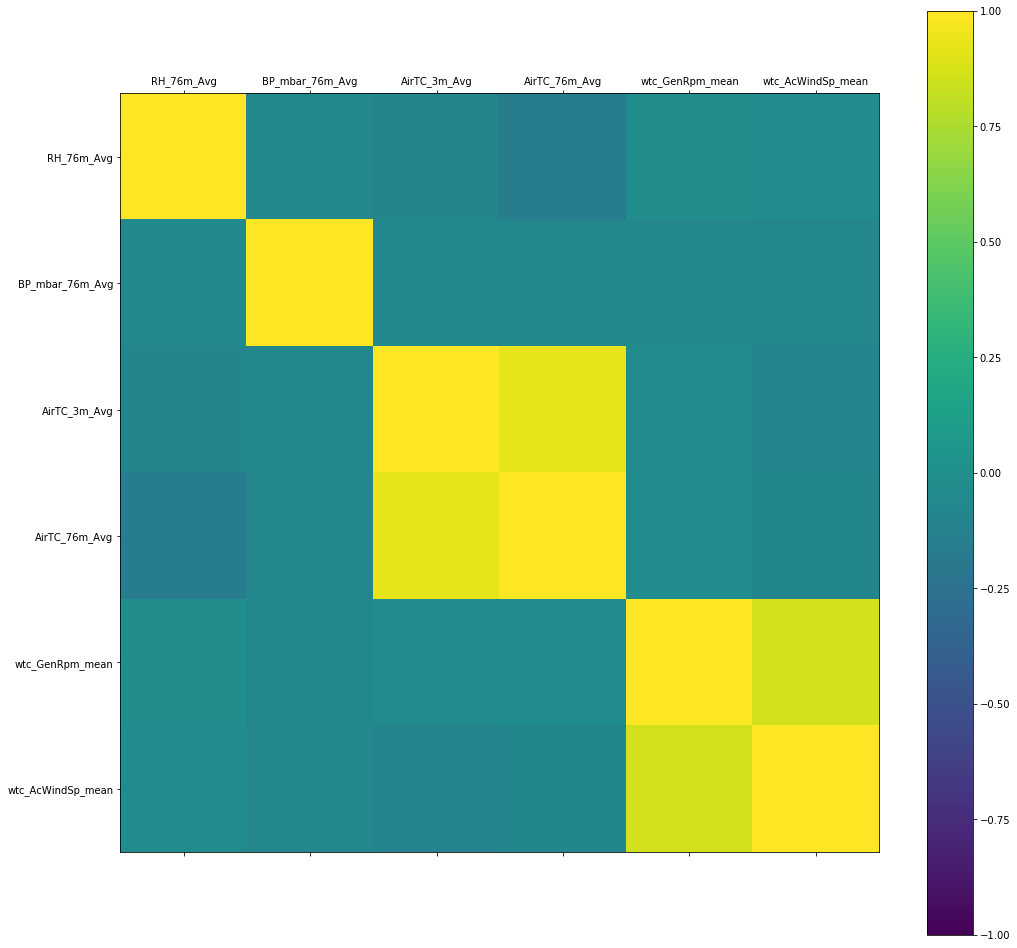

In [42]:
names = ['RH_76m_Avg', 'BP_mbar_76m_Avg', 'AirTC_3m_Avg','AirTC_76m_Avg','wtc_GenRpm_mean','wtc_AcWindSp_mean']
correlations = df.corr()
# plot correlation matrix
fig = plt.figure(figsize=(17,17))
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,6,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()

### [10 points] Identify and explain interesting relationships between features and the class you are trying to predict (i.e., relationships with variables and the target classification).

From this correlation plot we can see that wind speed is clearly the most predictive factor on turbine rpm. This is expected, but there is a slight negative correlation for rpm vs the other factors. Barometric pressure seems to have the most negative correlation while air temperature and humidity have about an equal small negative effect.